# Evaluate results with the Brier Skill Score (BSS)
In this notebook, we will now evaluate the quality of our forecasts using the BSS. The BSS is a probabilistic metric, and provides another perspective on the usefullness of a forecast than the AUC under the ROC.

## Import libraries

In [51]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal, stats
import datetime as dt
import feather
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, auc

## Load GLM results
We will use results from the GLM forecasting

In [2]:
results = feather.read_dataframe(r'data/all_patients_no_cross_auto_ts_test_day_acausal4.feather')
results

patient      score_method  preds_test  test_Sz  cov_test_IEA   time  \
0       None              None         NaN      NaN           NaN    NaN   
1         BJ  prop_time_corr_1    0.140870      0.0     -0.482539    1.0   
2         BJ  prop_time_corr_1    0.119790      0.0     -0.379885    2.0   
3         BJ  prop_time_corr_1    0.121372      0.0     -0.687848    3.0   
4         BJ  prop_time_corr_1    0.144757      0.0     -0.379885    4.0   
...      ...               ...         ...      ...           ...    ...   
8454      WP  prop_time_corr_1    0.707840      0.0     -0.211298  555.0   
8455      WP  prop_time_corr_1    0.708469      0.0     -0.285971  556.0   
8456      WP  prop_time_corr_1    0.611408      0.0     -0.565994  557.0   
8457      WP  prop_time_corr_1    0.465036      1.0     -0.547326  558.0   
8458      WP  prop_time_corr_1    0.326436      0.0      0.498094  559.0   

       cov_choice  
0            None  
1       week_hist  
2       week_hist  
3       week_hist  
4       week_hist  
...           ...  
8454  phase_multi  
8455  phase_multi  
8456  phase_multi  
8457  phase_multi  
8458  phase_multi  

[8459 rows x 7 columns]

We select patient JE for the multidien covariate.

In [19]:
idx_pat_multi = np.where((results.patient == 'JE') & (results.cov_choice == 'phase_multi'))
predictions_multi = results.preds_test.iloc[idx_pat_multi].to_numpy()
seizures_multi = results.test_Sz.iloc[idx_pat_multi].to_numpy().astype('int')

Find the indices for the seizures

In [7]:
idx_S_multi = np.where(seizures_multi>=1)

Plot the predictions and actual seizures

In [11]:
axs.plot

<bound method Axes.plot of <AxesSubplot:>>

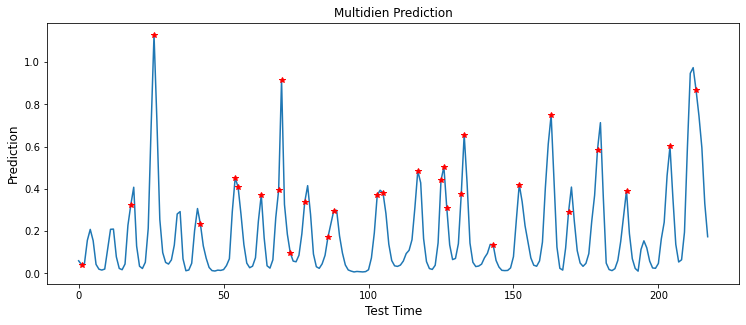

In [20]:
fig, axs = plt.subplots(1, 1,figsize=(12.4, 4.8))
axs.plot(predictions_multi)
axs.plot(idx_S_multi[0],predictions_multi[idx_S_multi],'r*')
plt.xlabel('Test Time',fontsize=12)
plt.ylabel('Prediction',fontsize=12)
axs.set_title('Multidien Prediction')
plt.show()

## Plot the reliability diagram

In [52]:
bin_edges = stats.mstats.mquantiles(predictions_multi, np.arange(0., 1., 0.05)) 
bin_edges= list(bin_edges)

In [54]:
rel_all = []
ledges = [0, *bin_edges, 1]
lx = []
for ixbin, xbin in enumerate(ledges[:-1]):
    curr_y = seizures_multi[(predictions_multi>xbin) & (predictions_multi<=ledges[ixbin+1])]
    rel_all.append(np.sum(curr_y)/curr_y.shape[0])
    lx.append(np.mean(predictions_multi[(predictions_multi>xbin) & (predictions_multi<=ledges[ixbin+1])]))

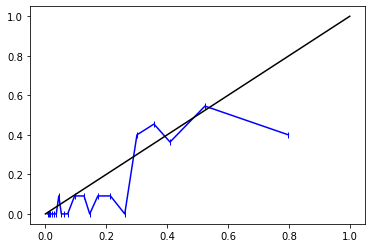

In [56]:
plt.plot(np.array(lx), rel_all, marker='|', color='b')
plt.plot([0, 1], [0, 1], 'k')

## Compute Brier score
TODO text

In [60]:
BS = np.mean((predictions_multi - seizures_multi)**2)
BS

0.09535654192030066

In [61]:
predictions_multi

array([0.05983779, 0.0411461 , 0.04677382, 0.15648213, 0.20829422,
       0.15516065, 0.04273648, 0.02005656, 0.01583488, 0.02067385,
       0.11511696, 0.20872923, 0.20985959, 0.07871929, 0.02362615,
       0.01751239, 0.04449963, 0.22767327, 0.32463562, 0.40785195,
       0.12931051, 0.03404005, 0.02330856, 0.05258424, 0.21271415,
       0.6934499 , 1.12955846, 0.72032189, 0.25532992, 0.09857455,
       0.05205131, 0.0442924 , 0.06406485, 0.13401236, 0.2812861 ,
       0.29251805, 0.06894057, 0.01268624, 0.01614703, 0.04799993,
       0.20282946, 0.30708282, 0.23371411, 0.13024884, 0.07177292,
       0.0282444 , 0.01339052, 0.01134076, 0.01553509, 0.01432155,
       0.01817492, 0.03715701, 0.06953552, 0.29196068, 0.45224403,
       0.40914419, 0.28053357, 0.13669673, 0.04870592, 0.0269726 ,
       0.03439769, 0.07418121, 0.24691375, 0.37222834, 0.16805841,
       0.03614297, 0.02501871, 0.06432923, 0.26359703, 0.39541485,
       0.91659386, 0.32671835, 0.18510013, 0.09799765, 0.05831

Reference

In [68]:
np.mean((shuffle_preds  -seizures_multi)**2)

0.16117824917713508

In [70]:
BS_ref = []
for irandom in range(1000):
    shuffle_preds = np.random.choice(predictions_multi, predictions_multi.shape[0], replace=False)
    BS_ref.append(np.mean((shuffle_preds - seizures_multi)**2))
BS_ref = np.mean(BS_ref)
BS_ref

0.1613370047955462

In [71]:
BSS = 1 - (BS/BS_ref)
BSS

0.40896050449714905

## Simulated data

We simulate both the IEA and the Seizures with a Poisson process with a periodic lambda.

Define the variables

In [46]:
dt = 1/24
T = 10000
t = np.arange(0,T,dt)
N=len(t)
lam = np.zeros(shape=(N,1))
lam_seiz = np.zeros(shape=(N,1))
Y = np.zeros(shape=(N,1))
Y_Seiz = np.zeros(shape=(N,1))
X = np.zeros(shape=(N,1))
X_Seiz = np.zeros(shape=(N,1))

We define the underlying rhythm as a cosinus that change period every 500 days. In our first model, both underlying rhythms, IEA (X) and Seizures (X_Seiz) share the same periodicity. The phase-shift indicates the shift between the IEA and Seizures.

In [47]:
Phase_shift=0.5*math.pi
nchanges=round(T/500)
step=24*500
ini=0  
fin=step
for i in range(nchanges):
    Period=round(np.random.uniform(4,45))
#    Period=30
    X[ini:fin,0] = np.cos((2*math.pi/(Period))*t[ini:fin])
    X_Seiz[ini:fin,0]=np.cos(Phase_shift+(2*math.pi/(Period))*t[ini:fin])
    ini=ini+step
    fin=fin+step
X[fin:,0]=np.cos((2*math.pi/(Period))*t[fin:])
X_Seiz[fin:,0]=np.cos(math.pi+(2*math.pi/(Period))*t[fin:])

We plot the underlying rhythm to se how it looks like.

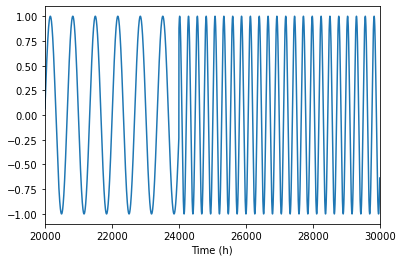

In [48]:
plt.figure()
plt.plot(X)
plt.xlim([20000,30000])
plt.xlabel('Time (h)')
plt.show()

### Model parameters

We have several parameters that control the model:
   - Baseline: baseline IEA, the more the less important is the IEA cycle
   - IEALevel: strength of the IEA cycle.
   - SeizureLevel: same as above but for seizures
   - NoiseSeiz: to make seizures appear independently of the underlying cycle.

Both IEA and Seizure generated based on a poisson process with a lambda as the underlying rhythm we just defined

In [51]:
randomN=np.random.uniform(size=(N,3))
BaselineSeiz=3 
NoiseSeiz=0
Noise=1
IEALevel=4.5
SeizureLevel=4.5
for i in range(N):               
    lam[i] = np.exp(-4.5 +  IEALevel*X[i])/dt+BaselineSeiz
    lam_seiz[i]= np.exp(-4.5 +  SeizureLevel*X_Seiz[i])
    p = lam[i]*dt 
    p_seiz=lam_seiz[i]*dt+NoiseSeiz*randomN[i,2]
    if p > randomN[i,0]:
        Y[i]=1 
    if p_seiz > randomN[i,1]:    
        Y_Seiz[i]=1

Put the data in "daily" counts and normalize

In [62]:
IEA=Y.reshape(T,24)
Seiz=Y_Seiz.reshape(T,24)
Real_risk=lam_seiz.reshape(T,24)
IEA=np.sum(IEA,1)
Seiz=np.sum(Seiz,1)
Real_risk=np.mean(Real_risk,1)
# noise in the counts
IEA=IEA+Noise*np.random.uniform(size=(IEA.shape[0]))
mean_IEA, std_IEA = np.mean(IEA, 0), np.std(IEA, 0)
IEA = (IEA - mean_IEA)/std_IEA
Seiz[np.where(Seiz>1)]=1
PosSeiz=np.where(Seiz==1)
print('Nº Seiz %0.0f' %len(PosSeiz[0]))

Nº Seiz 2171


Plot the data. No the the Seizure risk shift to the IEA

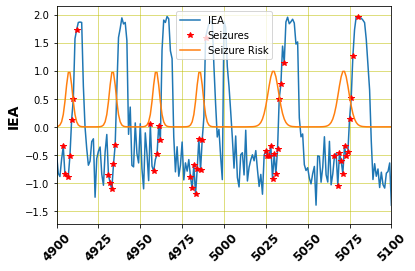

In [55]:
tt=t[::24]
plt.figure()
plt.plot(tt,IEA)
plt.plot(tt[PosSeiz],IEA[PosSeiz],'r*')
plt.plot(tt,lam_seiz[::24])
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.xlim((4900, 5100))
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['IEA','Seizures','Seizure Risk'])
plt.show()

Reorganize the data

Use back history of the IEA to predict seizures

In [63]:
n_past=50
n_future=1
x=[]
y=[]
risk=[]
for i in range(0,len(IEA)-n_past-n_future+1):
    x.append(IEA[i : i + n_past])     
    y.append(Seiz[i + n_past : i + n_past + n_future])
    risk.append(Real_risk[i + n_past : i + n_past + n_future])
x = np.array(x)

Shape of training inputs, training target: (4975, 50) (4975, 1)
Shape of test inputs, training target: (4975, 50) (4975, 1)


Define train and test set

In [ ]:
TestL=round(x.shape[0]/2)    
    
x_train = x[:TestL,:]
y_train = y[:TestL]
x_test = x[TestL:,:]
y_test = y[TestL:]
risk=risk[TestL:]

x_train , y_train = np.array(x_train), np.array(y_train)
x_test , y_test = np.array(x_test), np.array(y_test)
print('Shape of training inputs, training target:', x_train.shape, y_train.shape)
print('Shape of test inputs, training target:', x_test.shape, y_test.shape)

In [64]:
Nodes = 32
input_layer = Input(shape=(x_train.shape[1],1), dtype='float32')
GRUlayer = keras.layers.GRU(Nodes)(input_layer)
Dense_lay = Dense(32)(GRUlayer)
dropout_layer = Dropout(0.2)(Dense_lay)
output_layer = Dense(1,activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy")
model.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________________


In [70]:
# fit the model and prediction
history=model.fit(x=x_train, y=y_train,validation_split=0.15, batch_size=200, epochs=50, verbose=0, shuffle=False)
y_pred = model.predict(x_test, batch_size=200)
val_loss   = history.history['val_loss']
train_loss = history.history['loss']
print('Model fitted, val loss:', val_loss[49])

Model fitted, val loss: 0.24097149074077606


We plot the real risk vs the predicted risk of the model

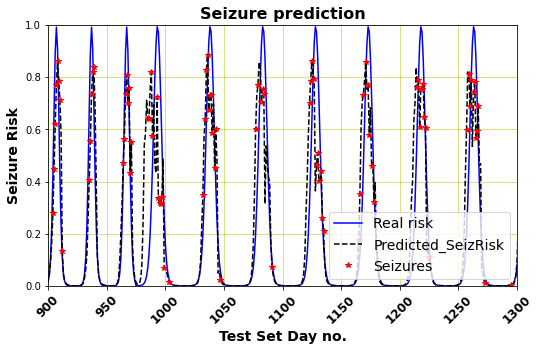

In [75]:
PosSeiz=np.where(y_test==1)
plt.figure(figsize=(8.4,4.8))
plt.plot(risk,color='b')
plt.plot(y_pred,linestyle='dashed',color='k')
plt.plot(PosSeiz,y_pred[PosSeiz,0],'r*')
plt.legend(['Real risk','Predicted_SeizRisk','Seizures'], loc='best', prop={'size': 14})
plt.title('Seizure prediction', weight='bold', fontsize=16)
plt.ylabel('Seizure Risk', weight='bold', fontsize=14)
plt.xlim((900, 1300))
plt.ylim((0,1))
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

Compute and plot the ROC curve

Area under the ROC curve: 0.91
Length of the test set: 4975 Nº of seizures: 1102


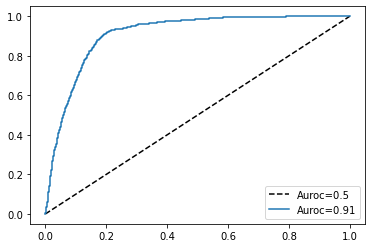

In [77]:
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
inseiz=np.where(y_test == 1)
numS=len(inseiz[0])
print('Area under the ROC curve: %.2f' % auroc)
print('Length of the test set: %.0f Nº of seizures: %.0f' %(len(y_test),numS))
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auroc))
plt.legend(['Auroc=0.5','Auroc=%0.2f' %(auroc)])
plt.show()